In [1]:
import pandas as pd
dataset = pd.read_csv("../../Data/cleaned_v1.csv")
dataset

,Unnamed: 0,Content,Label,Content_cleaned,Length_content_cleaned
0,0,Sao Việt ngày 29/3: NSƯT Chí Trung cùng bạn gá...,entertainment,việt nsưt chí_trung gái đi du_lịch mỹ ...,21
1,1,Người tiêu dùng trẻ ngày càng có xu hướng chi ...,business,tiêu_dùng trẻ xu_hướng chi_tiêu thông_minh tận...,311
2,2,Trong khuôn viên rất rộng ở khu liên hợp thể t...,sport,khuôn_viên rộng khu liên_hợp thể_thao techo mo...,253
3,3,Một trong những triệu chứng điển hình của tiểu...,health,triệu_chứng điển_hình tiểu tần_suất đi_tiểu nư...,287
4,4,"Từ ngày 27/2-2/3, Hiệp hội golf Việt Nam tổ ch...",sport,hiệp_hội golf việt_nam tổ_chức vòng_lo...,105
...,...,...,...,...,...
24409,2920,"Ở nội dung đôi nam nữ, Trần Ngọc Thúy Vi và Lê...",sport,nội_dung đôi nam_nữ trần_ngọc thúy_vi lê_hoà...,149
24410,2924,Nguồn: Next Sports Thiên Bình,sport,next sports thiên_bình,3
24411,2925,Nhận định trận đấu giữa Arsenal vs Brighton Tr...,sport,nhận_định trận_đấu arsenal vs brighton khuôn_k...,156
24412,2926,Dù giành chiến thắng trước Myanmar ở vòng bảng...,sport,giành chiến_thắng myanmar vòng bảng hlv mai_đứ...,138


In [2]:
from gensim.models import Word2Vec
w2v = Word2Vec.load("../../FeatureEngineering/Vectorize/w2v_300_5window_cleaned_24krow_skipgram.model")

In [4]:
from keras_preprocessing.text import Tokenizer
from keras_preprocessing import sequence
from keras_preprocessing.sequence import pad_sequences

import numpy as np

tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
# label_tokenizer = Tokenizer()
# label_tokenizer.fit_on_texts(dataset["Label"])
# token_label_seq = np.array(label_tokenizer.texts_to_sequences(dataset['Label']))
tokenizer.fit_on_texts(dataset['Content_cleaned'])
sequences = tokenizer.texts_to_sequences(dataset['Content_cleaned'])

maxlen = 250
X = sequence.pad_sequences(sequences, maxlen=maxlen)
Y = pd.get_dummies(dataset['Label'])

In [5]:
import numpy as np

embedding_dim = 300
word_index = tokenizer.word_index
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))
print('num_words:', num_words)
for word, i in word_index.items():
    if word in w2v.wv.key_to_index:
            embedding_matrix[i] = w2v.wv[word]

num_words: 109106


In [53]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, LSTM, Bidirectional, Dropout

model = Sequential()
model.add(Embedding(num_words, embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False))
model.add(Bidirectional(LSTM(units=300, return_sequences= True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=150, return_sequences= False)))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 250, 300)          32731800  
                                                                 
 bidirectional_8 (Bidirectio  (None, 250, 600)         1442400   
 nal)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 250, 600)          0         
                                                                 
 bidirectional_9 (Bidirectio  (None, 300)              901200    
 nal)                                                            
                                                                 
 dense_21 (Dense)            (None, 64)                19264     
                                                                 
 dropout_12 (Dropout)        (None, 64)               

In [54]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

X_train, X_test, Y_train, Y_test = train_test_split(X, Y , test_size= 0.3, random_state= 42)
model.fit(X_train, Y_train, validation_split=0.1, epochs= 100, callbacks=[EarlyStopping(monitor = "val_loss", patience= 5), EarlyStopping(monitor = "val_accuracy", patience= 5)])

Epoch 1/100
481/481 [==============================] - 745s 2s/step - loss: 0.1541 - accuracy: 0.8315 - val_loss: 0.0934 - val_accuracy: 0.9064
Epoch 2/100
481/481 [==============================] - 6794s 14s/step - loss: 0.0884 - accuracy: 0.9108 - val_loss: 0.0726 - val_accuracy: 0.9269
Epoch 3/100
481/481 [==============================] - 854s 2s/step - loss: 0.0942 - accuracy: 0.9029 - val_loss: 0.0772 - val_accuracy: 0.9233
Epoch 4/100
481/481 [==============================] - 850s 2s/step - loss: 0.0707 - accuracy: 0.9263 - val_loss: 0.0662 - val_accuracy: 0.9286
Epoch 5/100
481/481 [==============================] - 844s 2s/step - loss: 0.0645 - accuracy: 0.9353 - val_loss: 0.0658 - val_accuracy: 0.9304
Epoch 6/100
481/481 [==============================] - 833s 2s/step - loss: 0.0575 - accuracy: 0.9414 - val_loss: 0.0607 - val_accuracy: 0.9391
Epoch 7/100
481/481 [==============================] - 850s 2s/step - loss: 0.0549 - accuracy: 0.9452 - val_loss: 0.0624 - val_accurac

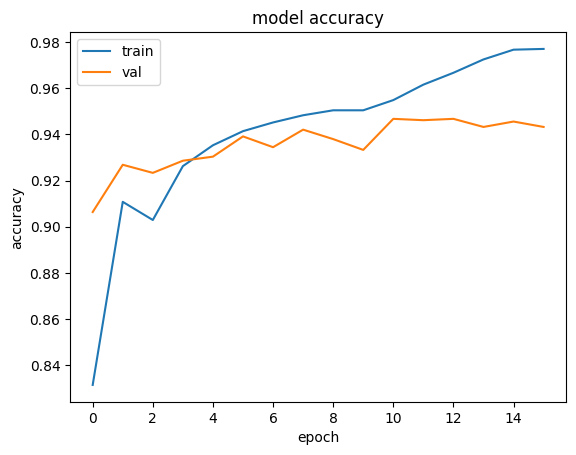

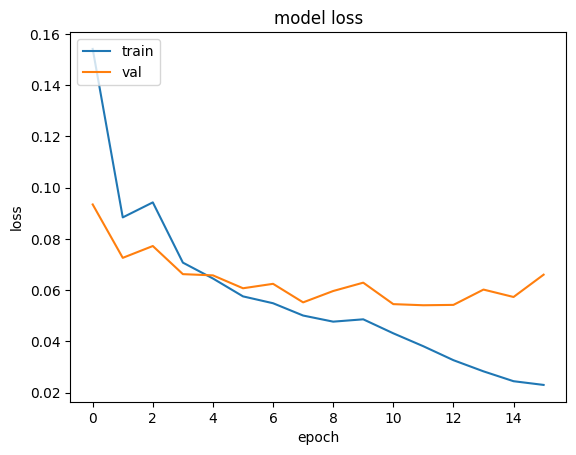

In [55]:
from matplotlib import pyplot as plt
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
from matplotlib import pyplot as plt
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [57]:
loss, accuracy = model.evaluate(X_test, Y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

229/229 [==============================] - 95s 416ms/step - loss: 0.0625 - accuracy: 0.9466
Test Loss: 0.06254503130912781
Test Accuracy: 0.9466211795806885


In [58]:
y_pred = model.predict(X_test)

229/229 [==============================] - 98s 415ms/step


In [59]:
predicted = y_pred.argmax(axis=1)

In [60]:
true_labels = Y_test.values.argmax(axis=1)

In [61]:
true_labels

array([2, 3, 0, ..., 3, 0, 2])

In [62]:
predicted

array([2, 3, 0, ..., 3, 0, 2])

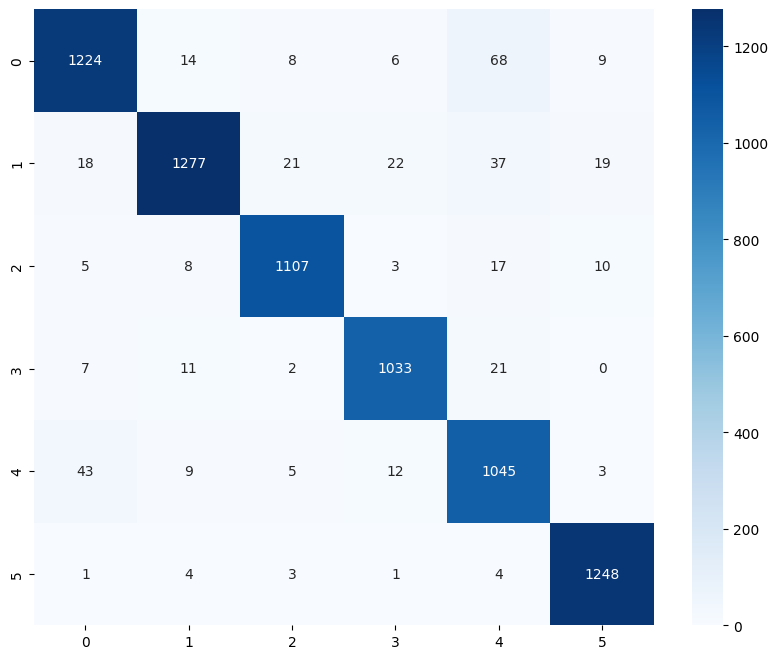

In [63]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def heatconmat(y_pred, y_test):
  plt.figure(figsize=(10,8))
  cnf_matrix = confusion_matrix(y_pred, y_test)
  ax = sns.heatmap(cnf_matrix, annot=True, fmt='', cmap='Blues')
  ax.xaxis.set_ticklabels(list(set(y_test)))
  ax.yaxis.set_ticklabels(list(set(y_test)))
  plt.show()
heatconmat(predicted, true_labels)